Две необходимых ссылки
https://pysindy.readthedocs.io/en/latest/examples/index.html

https://pysindy.readthedocs.io/en/latest/examples/2_introduction_to_sindy/example.html

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# import random

from plotly.subplots import make_subplots
from scipy.integrate import solve_ivp
import torch 

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


import pysindy as ps

# Генерация данных как в CRNN-модели

## Функция для вычисления приращений концентраций веществ

In [2]:
def true_ode_func(t: float, y: np.ndarray, k: np.ndarray) -> np.ndarray:
    """
    Вычисляет производные системы дифференциальных уравнений.
    
    Параметры:
    t : float
        Время (не используется в данном уравнении, но необходим для совместимости с solve_ivp).
    y : np.array
        Вектор переменных (y[0], y[1], ..., y[4]).
    k : np.array
        Константы скоростей реакций (k[0], k[1], ..., k[4]).

    Возвращает:
    dydt : numpy.ndarray
        Вектор производных.
    """
    
    dydt = np.empty_like(y)                          # можно использовать np.zeros_like(y), но это быстрее
    dydt[0] = -2 * k[0] * y[0]**2 - k[1] * y[0]
    dydt[1] = k[0] * y[0]**2 - k[3] * y[1] * y[3]
    dydt[2] = k[1] * y[0] - k[2] * y[2]
    dydt[3] = k[2] * y[2] - k[3] * y[1] * y[3]
    dydt[4] = k[3] * y[1] * y[3]
    return dydt

## Константы

In [3]:
N_REACTION = 4                                                       # кол-во реакций
N_SUBSTANCE = 5                                                      # кол-во веществ
VR_TIME = 30                                                         # время протекания реакций
INIT_CONC = np.array([2.8, 2.5, 2.1, 2, 2])                          # начальные концентрации веществ
k = torch.tensor([0.1, 0.2, 0.13, 0.3], dtype=torch.float32)         # константы скоростей реакций

tspan = [0.0, VR_TIME]                                               # временной промежуток
tsteps = np.linspace(tspan[0], tspan[1], VR_TIME*3 + 1)                # шаги по временному промежутку (количество точек)

# Стехиометрическая матрица (матрица реакций) в базовом виде
MATR = np.array([
    [-2, 1, 0, 0, 0],
    [-1, 0, 1, 0, 0],
    [0, 0, -1, 1, 0],
    [0, -1, 0, -1, 1]
])

MATR_PLUS = np.where(MATR < 0, -MATR, 0)
print(MATR_PLUS)

[[2 0 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 1 0 1 0]]


## Вычисление и визуализация изменения концентраций веществ со временем

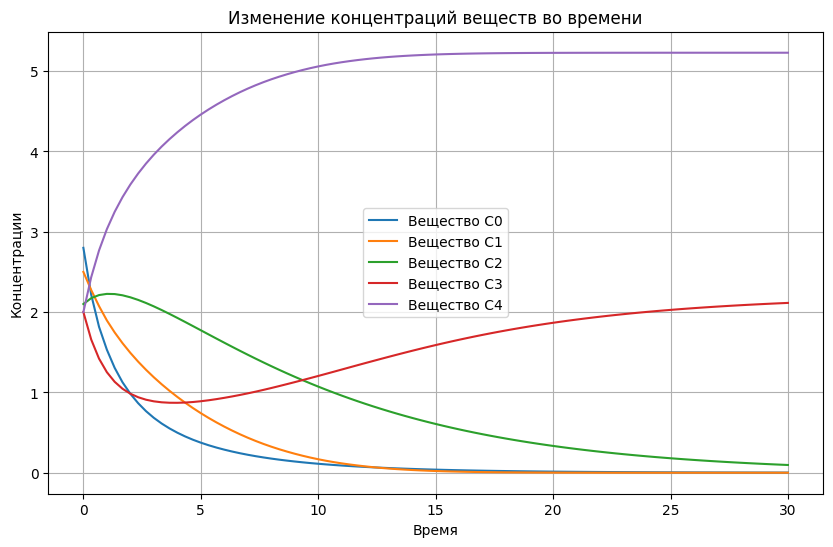

Начальные концентрации:        [2.8 2.5 2.1 2.  2. ]
Сумма концентраций веществ:    11.4
Концентрации после 30 секунд:  [0.12016759 0.18854856 1.11192221 1.17883187 5.03732708]
Сумма концентрций веществ:     7.636797312162332


In [4]:
sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        INIT_CONC,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, sol.y[i], label=f'Вещество C{i}')

plt.title('Изменение концентраций веществ во времени')
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()

print("Начальные концентрации:       ", INIT_CONC)
print("Сумма концентраций веществ:   ", sum(INIT_CONC))
print(f"Концентрации после {VR_TIME} секунд:  {sol.y[:, VR_TIME - 1]}")
print("Сумма концентрций веществ:    ", sum(sol.y[:, VR_TIME - 1]))

# Сохранение сгенерированных концентраций C в моменты времени. Понадобятся в будущем
CONC_TRUE = sol.y.copy()

## Вычисление приращений концентраций со временем (прямая задача)

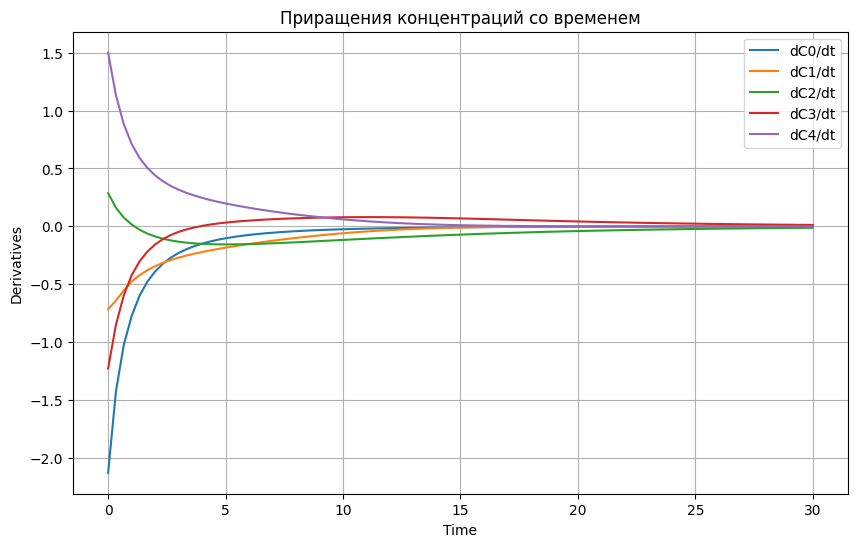

In [5]:
dCdt_TRUE = np.array([true_ode_func(t, y, k) for t, y in zip(sol.t, sol.y.T)]).T      # Приращения по истинным концентрациям C

plt.figure(figsize=(10, 6))
for i in range(dCdt_TRUE.shape[0]):
    plt.plot(sol.t, dCdt_TRUE[i], label=f'dС{i}/dt')

plt.title('Приращения концентраций со временем')
plt.xlabel('Time')
plt.ylabel('Derivatives')
plt.legend()
plt.grid()
plt.show()

# Добавление шума

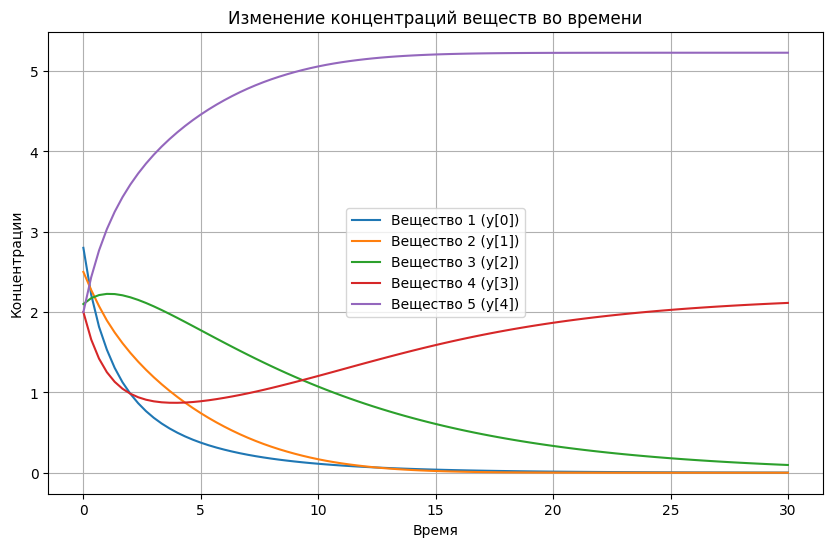

In [6]:
# Генерация шума
noise_level = 5e-2  # Уровень шума

# Создание копии, чтобы работать с ней
y_noisy = sol.y.copy()

# Генерация шума и его добавление
# noise = np.random.normal(0, noise_level * np.abs(y_noisy))
# y_noisy += noise

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, y_noisy[i], label=f'Вещество {i+1} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')  
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
print(y_noisy[0])
# Это вывод зашумленных точек первой концентрации

[2.80000000e+00 2.21597408e+00 1.81634217e+00 1.53201080e+00
 1.30487433e+00 1.12599297e+00 9.83035236e-01 8.65297446e-01
 7.66493812e-01 6.83269092e-01 6.12540588e-01 5.51671608e-01
 4.98488445e-01 4.51731453e-01 4.10580559e-01 3.74234001e-01
 3.41974282e-01 3.13168166e-01 2.87266684e-01 2.63840599e-01
 2.42652899e-01 2.23475503e-01 2.06093608e-01 1.90308373e-01
 1.75936918e-01 1.62812324e-01 1.50783635e-01 1.39716829e-01
 1.29532930e-01 1.20167587e-01 1.11549252e-01 1.03611350e-01
 9.62922786e-02 8.95354079e-02 8.32890811e-02 7.75066144e-02
 7.21475024e-02 6.71808149e-02 6.25762848e-02 5.83053614e-02
 5.43415566e-02 5.06604442e-02 4.72396607e-02 4.40589241e-02
 4.11003574e-02 3.83478108e-02 3.57861714e-02 3.34013546e-02
 3.11803045e-02 2.91109934e-02 2.71824182e-02 2.53846839e-02
 2.37086751e-02 2.21458387e-02 2.06881823e-02 1.93282743e-02
 1.80592441e-02 1.68748300e-02 1.57693136e-02 1.47373271e-02
 1.37738359e-02 1.28741390e-02 1.20338681e-02 1.12490033e-02
 1.05158665e-02 9.831005

# Полиномиальные аппроксимаций функции изменения концентраций

Вещество C0: R^2 = 0.999306
Свободный коэффициент: 2.739178
Коэффициенты полинома, начиная с x^1:
-1.6250688332, 0.5355456577, -0.1055691996, 0.0127744231, -0.0009681628, 0.0000460005, -0.0000013286, 0.0000000213, -0.0000000001

Вещество C1: R^2 = 0.999991
Свободный коэффициент: 2.496909
Коэффициенты полинома, начиная с x^1:
-0.7219581724, 0.1514409721, -0.0264328304, 0.0031363326, -0.0002354317, 0.0000110260, -0.0000003127, 0.0000000049, -0.0000000000

Вещество C2: R^2 = 0.999993
Свободный коэффициент: 2.108126
Коэффициенты полинома, начиная с x^1:
0.2243608865, -0.1320177417, 0.0244774174, -0.0027318648, 0.0001957284, -0.0000089597, 0.0000002523, -0.0000000040, 0.0000000000

Вещество C3: R^2 = 0.999732
Свободный коэффициент: 1.969327
Коэффициенты полинома, начиная с x^1:
-1.0033269851, 0.3679202015, -0.0728789954, 0.0088226154, -0.0006670769, 0.0000315400, -0.0000009053, 0.0000000144, -0.0000000001

Вещество C4: R^2 = 0.999895
Свободный коэффициент: 2.029660
Коэффициенты полинома, на

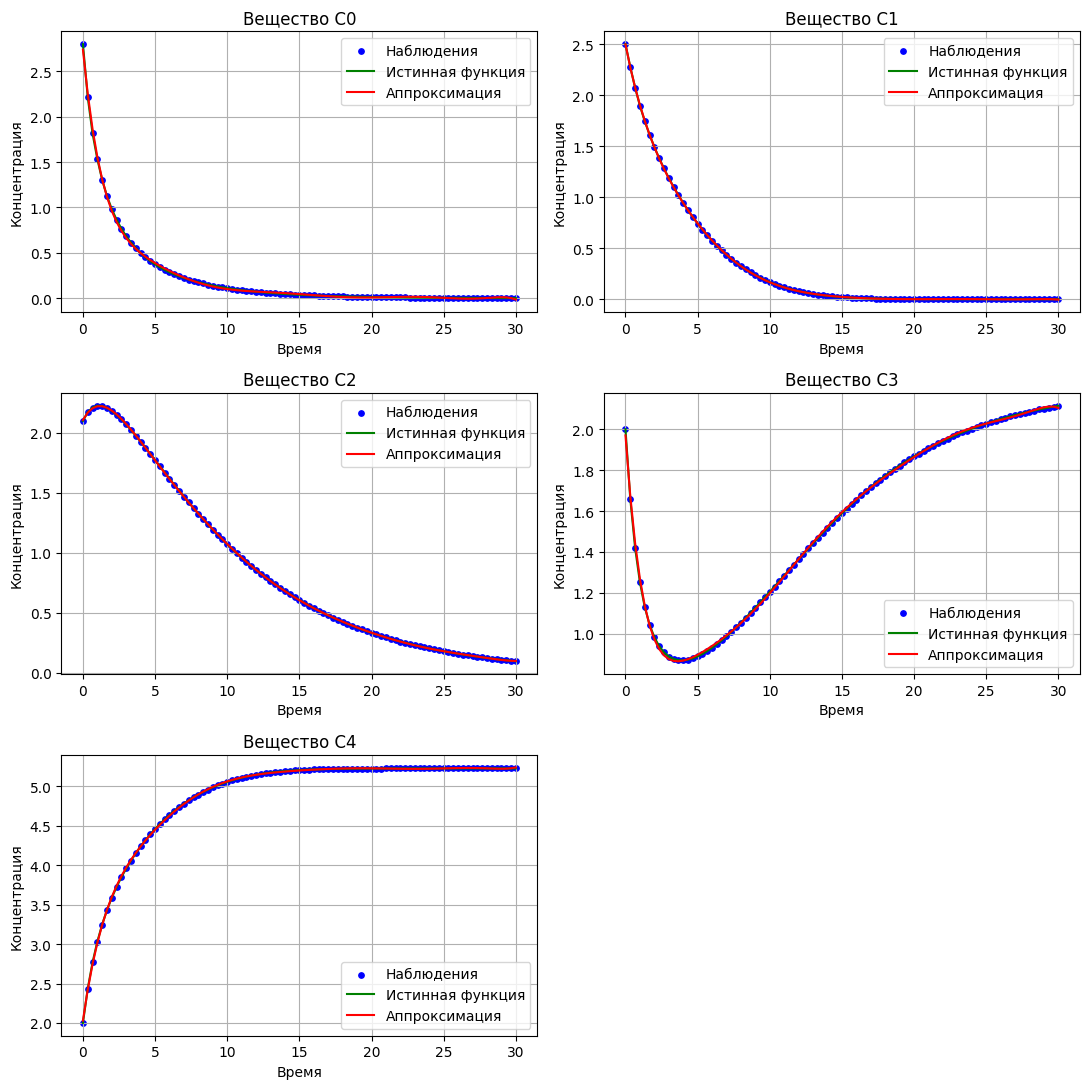

In [8]:
# Преобразование признаков в полиномиальные
poly_degree = 9                        # Задать степень полинома (нужно подбирать оптимальную)
poly = PolynomialFeatures(degree=poly_degree)
time_vec = sol.t.reshape(-1, 1)         # Изменение формата временного шага для метода из sklearn
t_poly = poly.fit_transform(time_vec)

# Определяем количество строк и столбцов для сетки графиков
rows, cols = (3, 2)  # Подходит для N_SUBSTANCE = 6
fig, axes = plt.subplots(rows, cols, figsize=(11, 11), squeeze=False)   # Размер общего окна

# Массив для коэффициентов полиномов
reaction_poly_coeffs = np.zeros((N_SUBSTANCE, poly_degree + 1))  # Массив из 5 строк и 9 столбцов. Тут будут храниться коэффициенты полиномов 
                                                   # Столбцы - число коэффициентов полинома, строки - концентрации веществ

# Перебираем вещества
for i in range(N_SUBSTANCE):
    y = y_noisy[i]  # Преобразование в 1D массив

    # Создаем и обучаем модель полиномиальной регрессии
    model = LinearRegression()
    model.fit(t_poly, y)
    y_pred = model.predict(t_poly)

    # Определяем текущую ось
    ax = axes[i // cols, i % cols]
    
    # Строим график
    ax.scatter(time_vec, y, color='blue', label='Наблюдения', s=15)
    ax.plot(sol.t, CONC_TRUE[i], color='green', label='Истинная функция')
    ax.plot(time_vec, y_pred, color='red', label='Аппроксимация')
    
    # Настройка графика
    ax.set_title(f'Вещество C{i}')
    ax.set_xlabel('Время')
    ax.set_ylabel('Концентрация')
    ax.legend()
    ax.grid()

    # Сохранение коэффициентов полинома
    reaction_poly_coeffs[i, 0] = model.intercept_
    reaction_poly_coeffs[i, 1:] = model.coef_[1:]  # Пропускаем свободный член
    
    # Вывод коэффициентов
    r2 = model.score(t_poly, y)
    print(f"Вещество C{i}: R^2 = {r2:.6f}")
    print(f"Свободный коэффициент: {model.intercept_:.6f}")
    print("Коэффициенты полинома, начиная с x^1:")
    print(f"{', '.join(f'{coef:.10f}' for coef in model.coef_[1:])}\n")

# Убираем пустые графики
for j in range(N_SUBSTANCE, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout()
plt.show()


Здесь первый элемент `model.coef_[0]` = `0.00000000e+00` соответствует \(x^0\). Он, равен `0`, так как свободный член отдельно хранится в `model.intercept_`.

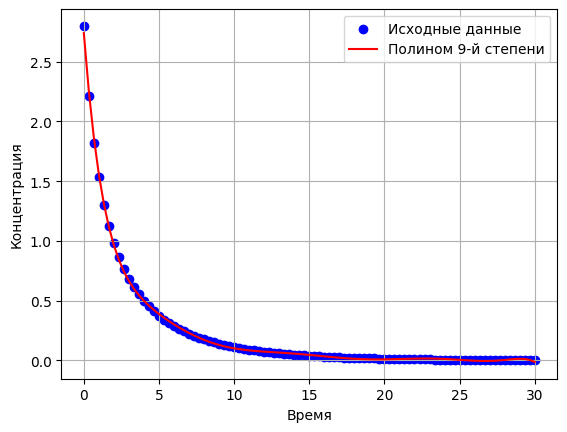

Коэффициенты полинома: [ 2.73957761e+00 -1.62391164e+00  5.34799347e-01 -1.05380036e-01
  1.27484363e-02 -9.66035105e-04  4.58938327e-05 -1.32538986e-06
  2.12460580e-08 -1.44873265e-10]


In [ ]:
# # Выбираем степень полинома
# degree = 9 # Например, квадратичная зависимость

# # Формируем матрицу признаков для полиномиальной регрессии
# X = np.vstack([tsteps**i for i in range(degree + 1)]).T

# # Вычисляем коэффициенты МНК
# theta = np.linalg.inv(X.T @ X) @ X.T @ y_noisy[0]

# # Предсказание значений
# # t_pred = np.linspace(min(t), max(t), 100)  # Генерируем новые точки для гладкости графика
# t_pred = tsteps
# X_pred = np.vstack([t_pred**i for i in range(degree + 1)]).T
# C_pred = X_pred @ theta

# # Визуализация
# plt.scatter(tsteps, y_noisy[0], label="Исходные данные", color="blue")
# plt.plot(t_pred, C_pred, label=f"Полином {degree}-й степени", color="red")
# plt.xlabel("Время")
# plt.ylabel("Концентрация")
# plt.legend()
# plt.grid()
# plt.show()

# # Вывод коэффициентов полинома 
# print(f"Коэффициенты полинома: {theta}")


### Визуализация полиномов в более презентабельном виде

In [10]:
# Функция для форматирования полинома
def format_polynomial(coefficients):
    terms = []
    for power, coef in enumerate(coefficients):
        if abs(coef) > 1e-10:  # Пропускать практически нулевые коэффициенты
            term = f"{coef:.5e}" if power == 0 else f"{coef:.5e}*t^{power}"
            terms.append(term)
    return " + ".join(terms).replace("+ -", "- ")  # Убираем лишние плюсы перед отрицательными числами

# Генерация и вывод полиномов
for i, coeffs in enumerate(reaction_poly_coeffs):
    print(f"C{i}(t) = ", end='')
    print(format_polynomial(coeffs))


C0(t) = 2.73918e+00 - 1.62507e+00*t^1 + 5.35546e-01*t^2 - 1.05569e-01*t^3 + 1.27744e-02*t^4 - 9.68163e-04*t^5 + 4.60005e-05*t^6 - 1.32859e-06*t^7 + 2.12989e-08*t^8 - 1.45242e-10*t^9
C1(t) = 2.49691e+00 - 7.21958e-01*t^1 + 1.51441e-01*t^2 - 2.64328e-02*t^3 + 3.13633e-03*t^4 - 2.35432e-04*t^5 + 1.10260e-05*t^6 - 3.12749e-07*t^7 + 4.91831e-09*t^8
C2(t) = 2.10813e+00 + 2.24361e-01*t^1 - 1.32018e-01*t^2 + 2.44774e-02*t^3 - 2.73186e-03*t^4 + 1.95728e-04*t^5 - 8.95971e-06*t^6 + 2.52260e-07*t^7 - 3.97084e-09*t^8
C3(t) = 1.96933e+00 - 1.00333e+00*t^1 + 3.67920e-01*t^2 - 7.28790e-02*t^3 + 8.82262e-03*t^4 - 6.67077e-04*t^5 + 3.15400e-05*t^6 - 9.05329e-07*t^7 + 1.44198e-08*t^8
C4(t) = 2.02966e+00 + 1.28265e+00*t^1 - 3.58110e-01*t^2 + 6.89455e-02*t^3 - 8.37928e-03*t^4 + 6.36792e-04*t^5 - 3.02109e-05*t^6 + 8.69053e-07*t^7 - 1.38615e-08*t^8


Нахождение производных от функций концентраций веществ

Так как в нашем случае в качестве функций используются только полиномы, то я напишу функцию вручную

`print(reaction_poly_coeffs)` - чтобы посмотреть массив с коэффициентами полиномов для каждого вещества

In [11]:
def differentiate_polynomial(coefficients):
    degree = len(coefficients) # степень полинома + 1
    return np.array([coefficients[i] * i for i in range(1, degree)])

reaction_poly_derivatives = np.array([differentiate_polynomial(coeff) for coeff in reaction_poly_coeffs])

print(reaction_poly_derivatives)

[[-1.62506883e+00  1.07109132e+00 -3.16707599e-01  5.10976924e-02
  -4.84081424e-03  2.76002784e-04 -9.30014886e-06  1.70391553e-07
  -1.30718036e-09]
 [-7.21958172e-01  3.02881944e-01 -7.92984911e-02  1.25453305e-02
  -1.17715864e-03  6.61557315e-05 -2.18924525e-06  3.93464572e-08
  -2.96244029e-10]
 [ 2.24360887e-01 -2.64035483e-01  7.34322521e-02 -1.09274592e-02
   9.78641801e-04 -5.37582537e-05  1.76582126e-06 -3.17666806e-08
   2.40402198e-10]
 [-1.00332699e+00  7.35840403e-01 -2.18636986e-01  3.52904615e-02
  -3.33538440e-03  1.89240016e-04 -6.33729988e-06  1.15358118e-07
  -8.79490480e-10]
 [ 1.28265042e+00 -7.16220041e-01  2.06836439e-01 -3.35171188e-02
   3.18395807e-03 -1.81265339e-04  6.08337276e-06 -1.10891970e-07
   8.46253068e-10]]


## Визуализация различий между приращениями в обратной и прямой задачах

### Оригинал (прямая задача)

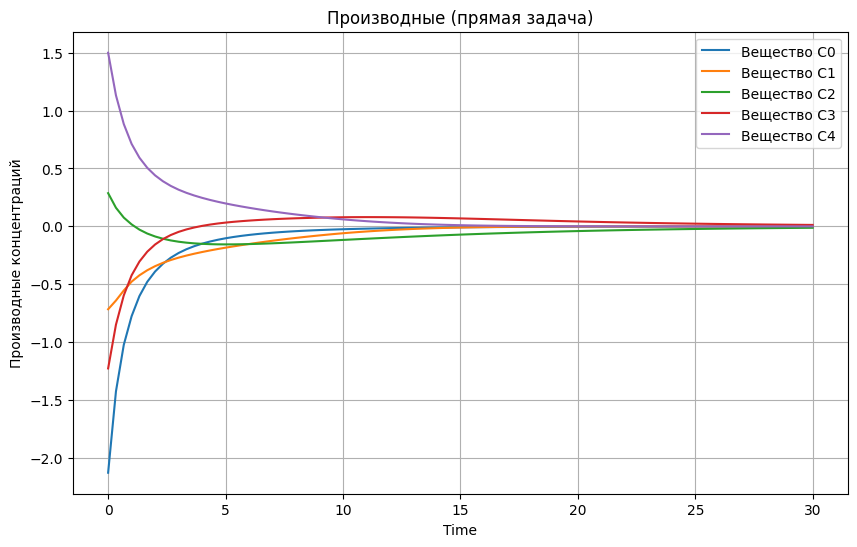

In [12]:
# Диапазон значений x
# x = np.linspace(0, 30, 61)    # Базово использовать tsteps

# Построение графиков
plt.figure(figsize=(10, 6))

for i in range(N_SUBSTANCE):
    plt.plot(tsteps, dCdt_TRUE[i], label=f'Вещество C{i}')

plt.xlabel('Time')
plt.ylabel('Производные концентраций')
plt.title('Производные (прямая задача)')
plt.legend()
plt.grid()
plt.show()


### Пародия (обратная задача)

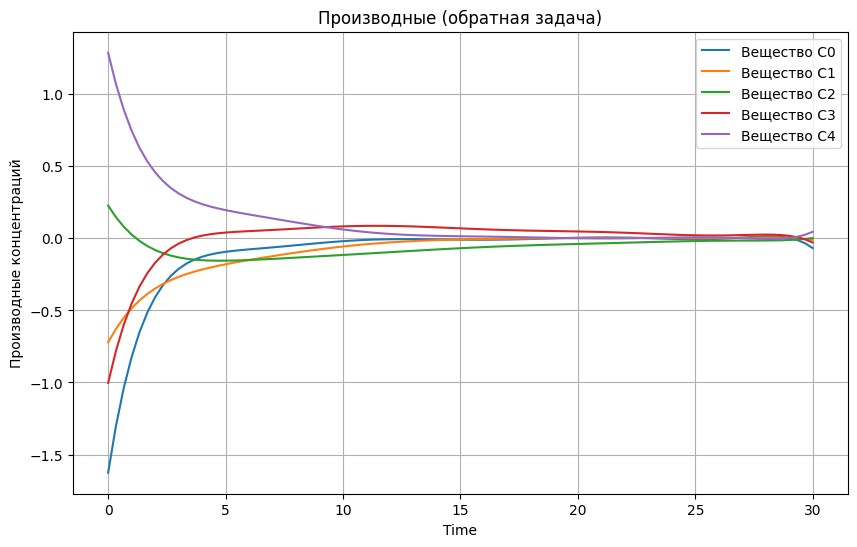

In [13]:
dCdt_predict = np.zeros_like(dCdt_TRUE)         # Приращения в обратной задаче

# Построение графиков
plt.figure(figsize=(10, 6))

for i, coeffs in enumerate(reaction_poly_derivatives):
    y = np.polyval(coeffs[::-1], tsteps)  # Вычисляем значения полинома
    dCdt_predict[i, :] = y

    # Вывод на график
    plt.plot(tsteps, dCdt_predict[i], label=f'Вещество C{i}')

plt.xlabel('Time')
plt.ylabel('Производные концентраций')
plt.title('Производные (обратная задача)')
plt.legend()
plt.grid()
plt.show()

### Приращения методом конечных разностей

In [14]:
h = tsteps[1] - tsteps[0]  # Шаг по времени

dC_dt = np.diff(y_noisy, axis=1) / h  # Приращения (разностная производная)

t_mid = (tsteps[:-1] + tsteps[1:]) / 2  # Средние точки, на одну меньше, т.к. считаем между точками

# Визуализация
fig = go.Figure()

# Добавляем линии для каждого вещества
for i in range(N_SUBSTANCE):
    fig.add_trace(go.Scatter(
        x=t_mid, 
        y=dC_dt[i], 
        mode='lines', 
        name=f'Приращение C{i}'
    ))

# Настройки графика
fig.update_layout(
    title='Производные по приращениям',
    xaxis_title='Time',
    yaxis_title='Производные концентраций',
    legend_title='Приращения',
    template='plotly_white',
    width=1000,  # Ширина холста
    height=600   # Высота холста
)

fig.show()

In [18]:
print(dC_dt)

[[-1.75207776e+00 -1.19889574e+00 -8.52994092e-01 -6.81409430e-01
  -5.36644063e-01 -4.28873211e-01 -3.53213368e-01 -2.96410903e-01
  -2.49674159e-01 -2.12185513e-01 -1.82606941e-01 -1.59549487e-01
  -1.40270975e-01 -1.23452683e-01 -1.09039674e-01 -9.67791582e-02
  -8.64183457e-02 -7.77044469e-02 -7.02782556e-02 -6.35631004e-02
  -5.75321878e-02 -5.21456844e-02 -4.73557053e-02 -4.31143658e-02
  -3.93737812e-02 -3.60860666e-02 -3.32004166e-02 -3.05516988e-02
  -2.80960292e-02 -2.58550044e-02 -2.38137056e-02 -2.19572144e-02
  -2.02706122e-02 -1.87389803e-02 -1.73474001e-02 -1.60773362e-02
  -1.49000623e-02 -1.38135904e-02 -1.28127701e-02 -1.18914146e-02
  -1.10433370e-02 -1.02623505e-02 -9.54221001e-03 -8.87569987e-03
  -8.25763984e-03 -7.68491843e-03 -7.15445036e-03 -6.66315033e-03
  -6.20793304e-03 -5.78572565e-03 -5.39320299e-03 -5.02802638e-03
  -4.68850918e-03 -4.37296918e-03 -4.07972416e-03 -3.80709061e-03
  -3.55324226e-03 -3.31654900e-03 -3.09595952e-03 -2.89047359e-03
  -2.69909

# Аппроксимация приращений полиномом

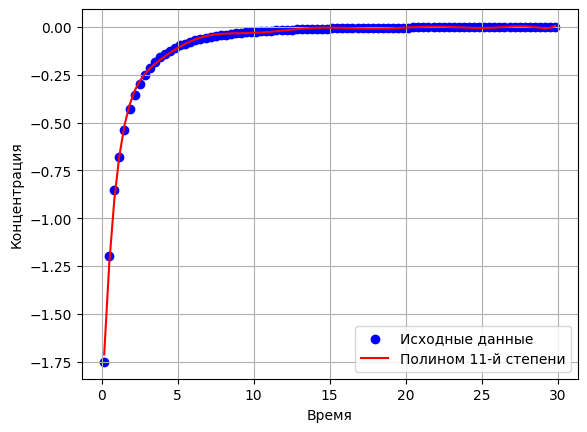

R2 =  0.9984741356054059
Коэффициенты полинома: [-2.01995108e+00  2.00238180e+00 -1.00709445e+00  2.95454065e-01
 -5.39973761e-02  6.42100016e-03 -5.09368658e-04  2.71493095e-05
 -9.59578310e-07  2.15555013e-08 -2.78491800e-10  1.57507789e-12]


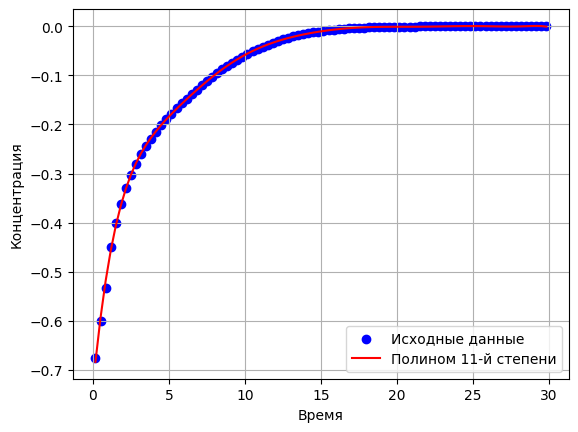

R2 =  0.9997360502096746
Коэффициенты полинома: [-7.35053260e-01  3.22475336e-01 -8.62669152e-02  1.24311711e-02
 -6.54577512e-04 -5.85157114e-05  1.24732665e-05 -9.75648414e-07
  4.29228981e-08 -1.11423095e-09  1.59707987e-11 -9.77316005e-14]


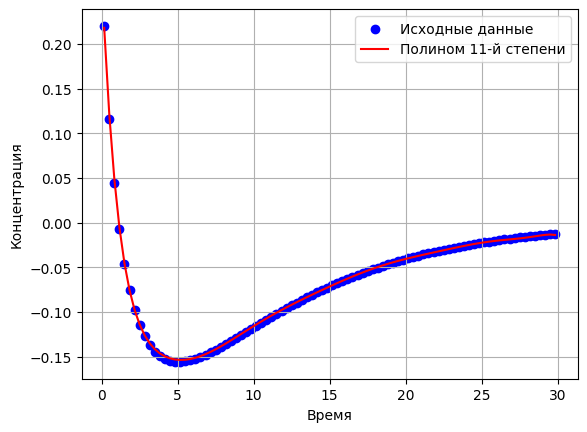

R2 =  0.9995623935936345
Коэффициенты полинома: [ 2.77369144e-01 -3.81901556e-01  1.58925863e-01 -4.05549783e-02
  6.81615119e-03 -7.69019480e-04  5.88786223e-05 -3.05923568e-06
  1.06067813e-07 -2.34704574e-09  2.99572533e-11 -1.67740545e-13]


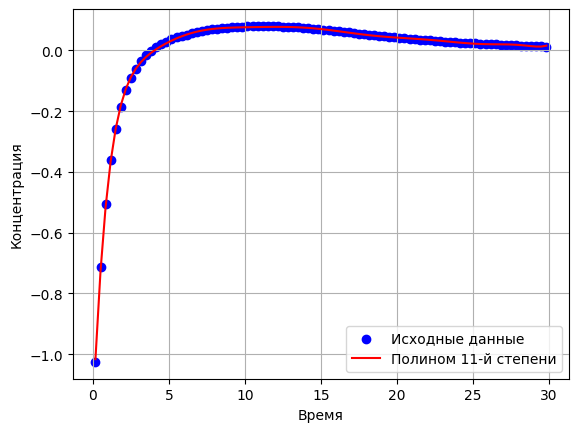

R2 =  0.9996566513820365
Коэффициенты полинома: [-1.19850959e+00  1.18091542e+00 -5.41319306e-01  1.47037631e-01
 -2.53388683e-02  2.88338075e-03 -2.21288238e-04  1.14994113e-05
 -3.98431303e-07  8.80784658e-09 -1.12301351e-10  6.28125374e-13]


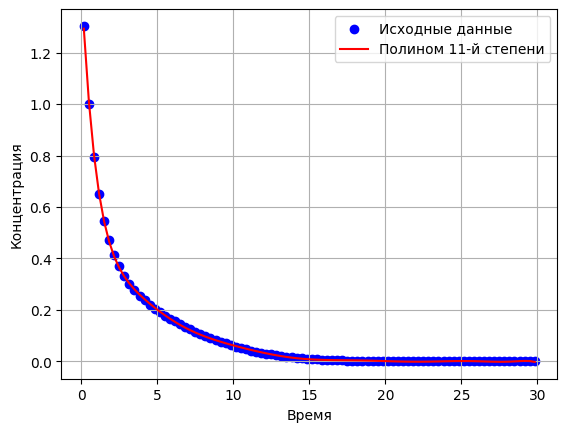

R2 =  0.9998427476595598
Коэффициенты полинома: [ 1.47039938e+00 -1.14878218e+00  5.20673957e-01 -1.42266370e-01
  2.46097527e-02 -2.80611039e-03  2.15610611e-04 -1.12127310e-05
  3.88698721e-07 -8.59594788e-09  1.09631447e-10 -6.13333246e-13]


In [28]:
# Выбираем степень полинома
degree = 11 # Например, квадратичная зависимость

for i in range(N_SUBSTANCE):
    # Формируем матрицу признаков для полиномиальной регрессии
    X = np.vstack([t_mid**i for i in range(degree + 1)]).T

    # Вычисляем коэффициенты МНК
    theta = np.linalg.inv(X.T @ X) @ X.T @ dC_dt[i]

    # Предсказание значений
    # t_pred = np.linspace(min(t), max(t), 100)  # Генерируем новые точки для гладкости графика
    t_pred = t_mid
    X_pred = np.vstack([t_pred**i for i in range(degree + 1)]).T
    C_pred = X_pred @ theta

    r2 = r2_score(dC_dt[i], C_pred)

    # Визуализация
    plt.scatter(t_mid, dC_dt[i], label="Исходные данные", color="blue")
    plt.plot(t_pred, C_pred, label=f"Полином {degree}-й степени", color="red")
    plt.xlabel("Время")
    plt.ylabel("Концентрация")
    plt.legend()
    plt.grid()
    plt.show()

    # Вывод R2 и коэффициентов полинома 
    print("R2 = ", r2)
    print(f"Коэффициенты полинома: {theta}")


## Различие между приращениями

### Прямая и обратная задачи

In [15]:
fig = go.Figure()

# Добавляем линии для каждого вещества
for i in range(N_SUBSTANCE):
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=dCdt_TRUE[i] - dCdt_predict[i], 
        mode='lines', 
        name=f'Приращение C{i}'
    ))

# Настройки графика
fig.update_layout(
    title='Производные концентраций веществ',
    xaxis_title='Time',
    yaxis_title='Производные концентраций',
    legend_title='Приращения',
    template='plotly_white',
    width=1000,  # Ширина холста
    height=600   # Высота холста
)

fig.show()

### Прямая и приращения

In [16]:
fig = go.Figure()

# Так как оригинальные приращения находятся в точках изначальных наблюдений, а приращения по численным методам в смещенных на ПОЛШАГА точках,
# нужно провести некоторую интерполяцию, чтобы дальше посчитать разницу в аналогичных точках.

# Добавляем линии для каждого вещества
for i in range(N_SUBSTANCE):
    dCdt_TRUE_mod = np.interp(t_mid, tsteps, dCdt_TRUE[i])       # Интерполяция для уменьшения размерности на 1
    fig.add_trace(go.Scatter(
        x=tsteps,
        y=dCdt_TRUE_mod - dC_dt[i], 
        mode='lines', 
        name=f'Приращение C{i}'
    ))

# Настройки графика
fig.update_layout(
    title='Производные концентраций веществ',
    xaxis_title='Time',
    yaxis_title='Производные концентраций',
    legend_title='Приращения',
    template='plotly_white',
    width=1000,  # Ширина холста
    height=600   # Высота холста
)

fig.show()

Неплохой результат. Затухает намного лучше

## Частотное что-то там

In [ ]:
fig = go.Figure()

# Дискретизация по времени (шаг)
dt = tsteps[1] - tsteps[0]  # Предполагаем, что шаг одинаковый

# Добавляем спектры для каждого вещества
for i, coeffs in enumerate(reaction_poly_derivatives):
    y = np.polyval(coeffs[::-1], tsteps)  # Вычисляем значения полинома
    signal = dCdt_TRUE[i] - y  # Исходный сигнал (разность производных)

    # Применяем БПФ (FFT)
    fft_values = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), d=dt)  # Вычисляем частоты

    # Берём только положительные частоты и нормируем амплитуды
    mask = freqs > 0
    freqs, fft_values = freqs[mask], np.abs(fft_values[mask])  

    # Добавляем в график
    fig.add_trace(go.Scatter(
        x=freqs, 
        y=fft_values, 
        mode='lines', 
        name=f'Частоты C{i}'
    ))

# Настройки графика
fig.update_layout(
    title='Частотный спектр производных концентраций',
    xaxis_title='Frequency (Hz)',
    yaxis_title='Amplitude',
    legend_title='Вещества',
    template='plotly_white',
    width=1000,
    height=600
)

fig.show()


In [ ]:
# Диапазон значений x
# t = np.linspace(0, 30, 100)       # Базово использовать tsteps

# Построение графиков
plt.figure(figsize=(10, 6))
for i, coeffs in enumerate(reaction_poly_coeffs):
    y = np.polyval(coeffs[::-1], tsteps)  # Вычисляем значения полинома
    plt.plot(tsteps, y, label=f'Вещество C{i}')

plt.xlabel('time')
plt.ylabel('Концентрации')
plt.title('Концентрации веществ по аппроксимациям')
plt.legend()
plt.grid()
plt.show()


# Проверяем концентрации

Статистика по ошибкам

In [ ]:
# шаг по времени
# t = np.linspace(0, 30, 31)
error_matrix = np.zeros_like(y_noisy)  # пустая матрица той же размерности

for i, coeffs in enumerate(reaction_poly_coeffs):
    y = np.polyval(coeffs[::-1], tsteps)  # Вычисляем значения полинома
    # error_matrix[i] = y_noisy[i] - y  # Заполняем матрицу ошибками
    error_matrix[i] = abs(y_noisy[i] - y)  # Заполняем матрицу ошибками

# Вычисляем статистики по всей матрице
max_value = np.max(error_matrix)
min_value = np.min(error_matrix)
mean_value = np.mean(error_matrix)
median_value = np.median(error_matrix)

# Вычисляем статистики по каждой строке
max_per_row = np.max(error_matrix, axis=1)
min_per_row = np.min(error_matrix, axis=1)
mean_per_row = np.mean(error_matrix, axis=1)
median_per_row = np.median(error_matrix, axis=1)

# Вывод общих статистик
print(f"Максимальное значение ошибки: {max_value:.6f}")
print(f"Минимальное значение ошибки: {min_value:.6f}")
print(f"Среднее значение ошибки: {mean_value:.6f}")
print(f"Медиана ошибки: {median_value:.6f}")

# Вывод статистик по каждой строке
# for i in range(error_matrix.shape[0]):
#     print(f"\nСтрока {i}:")
#     print(f"  Максимум: {max_per_row[i]:.6f}")
#     print(f"  Минимум: {min_per_row[i]:.6f}")
#     print(f"  Среднее: {mean_per_row[i]:.6f}")
#     print(f"  Медиана: {median_per_row[i]:.6f}")

# Вычисление k по данным обратной задачи

In [ ]:
k_predict = np.zeros((N_REACTION, len(tsteps)))                     # k предсказанные
k_TRUE = np.zeros((N_REACTION, len(tsteps)))                        # k по изначальным данным
k_test_1 = np.zeros((N_REACTION, len(tsteps)))                      # k для теста
k_test_2 = np.zeros((N_REACTION, len(tsteps)))                      # k для теста

W_predict = np.zeros((N_REACTION, len(tsteps)))                     # W(скорости реакций) предсказанные
W_TRUE = np.zeros((N_REACTION, len(tsteps)))                        # W(скорости реакций) по изначальным данным
W_test_1 = np.zeros((N_REACTION, len(tsteps)))                      # W для теста
W_test_2 = np.zeros((N_REACTION, len(tsteps)))                      # W для теста

C_predict = np.zeros((N_SUBSTANCE, len(tsteps)))                    # C(концентрации) предсказанные
C_TRUE = np.zeros((N_SUBSTANCE, len(tsteps)))                       # C(концентрации) по изначальным данным
C_test_1 = np.zeros((N_SUBSTANCE, len(tsteps)))                     # C для теста
C_test_2 = np.zeros((N_SUBSTANCE, len(tsteps)))                     # C для теста


In [ ]:
matrix_transformations = np.linalg.inv(MATR @ MATR.T) @ MATR

In [ ]:
print(matrix_transformations)

### Сохранение k по C-предсказанная, dC-предсказанная

In [ ]:
# t = np.linspace(0, 30, 31)         # Базово использовать tsteps

for i, val in enumerate(tsteps):
    W = matrix_transformations @ dCdt_predict.T[i]
    C = np.array([np.polyval(substance[::-1], val) for substance in reaction_poly_coeffs])
    result = np.prod(C ** MATR_PLUS, axis=1)

    W_predict[:, i] = W
    C_predict[:, i] = C
    k_predict[:, i] = W / result  # Заполняем i-й столбец матрицы k_pred

# print(k_pred)  # Выводим матрицу


### Сохранение k по С-начальная, dC-начальная

In [ ]:
# t = np.linspace(0, 30, 31)         # Базово использовать tsteps

for i, val in enumerate(tsteps):
    W = matrix_transformations @ dCdt_TRUE.T[i]
    C = CONC_TRUE[:, i]
    result = np.prod(C ** MATR_PLUS, axis=1)

    W_TRUE[:, i] = W
    C_TRUE[:, i] = C
    k_TRUE[:, i] = W / result  # Заполняем i-й столбец матрицы k_eval

# print(k_eval)  # Выводим матрицу


In [ ]:
print(k_TRUE)

## Генерация k в ходе обратной задачи 

In [ ]:
# Задаем цвета (4 цвета для реакций)
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['С-начальная, dC-начальная', 'С-предсказанная, dC-предсказанная'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_TRUE[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_predict[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1400,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


Скачки всё равно остаются, и чем дальше по времени, тем сильнее графики колбасит

# Test_1

### Вычисление k по C-начальная, dС-предсказанная
### Вычисление k по C-предсказанная, dС-начальная

In [ ]:
for i, val in enumerate(tsteps):
    W = W_predict[:, i]
    C = CONC_TRUE[:, i]
    result = np.prod(C ** MATR_PLUS, axis=1)

    k_test_1[:, i] = W / result  # Заполняем i-й столбец матрицы k_pred

for i, val in enumerate(tsteps):
    W = W_TRUE[:, i]
    C = C_predict[:, i]
    result = np.prod(C ** MATR_PLUS, axis=1)

    k_test_2[:, i] = W / result  # Заполняем i-й столбец матрицы k_eval

## Генерация k в ходе обратной задачи 

In [ ]:
# Задаем цвета (4 цвета для реакций)
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['C-начальная, dС-предсказанная', 'C-предсказанная, dС-начальная'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_test_1[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_test_2[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1400,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


##

In [ ]:
# Задаем цвета (4 цвета для реакций)
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['C-начальная, dС-предсказанная', 'C-предсказанная, dС-предсказанная'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_test_1[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_predict[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1700,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


In [ ]:
C_test_1 = np.abs(C_predict)

In [ ]:
for i, val in enumerate(tsteps):
    W = W_predict[:, i]
    C = C_test_1.T[i]
    result = np.prod(C ** MATR_PLUS, axis=1)

    k_test_1[:, i] = W / result  # Заполняем i-й столбец матрицы k_eval

In [ ]:
print(W_predict)

In [ ]:
# Задаем цвета (4 цвета для реакций)
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['C-модифицированная, dС-предсказанная', 'C-предсказанная, dС-предсказанная'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_test_1[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_predict[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1700,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


In [ ]:
# Задаем цвета (4 цвета для реакций)
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['C-модифицированная, dС-предсказанная', 'C-предсказанная, dС-предсказанная'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_test_1[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_test_2[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1700,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


## Вывод интересных графиков

In [ ]:
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['W-истинная', 'W-предсказанная'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=W_TRUE[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=W_predict[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1400,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-0.05, 0.2], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-0.05, 0.2], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


W-скорости реакций предсказываются отрицательными. Они не должны быть отрицательными

In [ ]:
colors = ['blue', 'red', 'green', 'purple','black']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['dCdt-истинная', 'dCdt-предсказанная'])

# Первый график
for i in range(N_SUBSTANCE):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=dCdt_TRUE[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график
for i in range(N_SUBSTANCE):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=dCdt_predict[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1400,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-0.5, 0.5], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-0.5, 0.5], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


In [ ]:
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['k-истинная', 'k-предсказанная'])

# Первый график
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_TRUE[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_predict[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1700,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-1, 1], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-1, 1], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


In [ ]:
# Точка в которой считаем значения
t_1 = 0.5
t_2 = 6
t_3 = 15

# Вычисление значения полиномов в точке t
dC_1 = np.array([np.polyval(substance[::-1], t_1) for substance in reaction_poly_derivatives])
dC_2 = np.array([np.polyval(substance[::-1], t_2) for substance in reaction_poly_derivatives])
dC_3 = np.array([np.polyval(substance[::-1], t_3) for substance in reaction_poly_derivatives])

print('Производные концентраций в моменты времени:')
print('dC(t=0.5) = ', dC_1)
print('dC(t=6)   = ', dC_2)
print('dC(t=12)  = ', dC_3)

# Вычисление значения скоростей реакций в моменты времени
W_1 = np.linalg.inv(MATR @ MATR.T) @ MATR @ dC_1  # t_1 = 0.5
W_2 = np.linalg.inv(MATR @ MATR.T) @ MATR @ dC_2  # t_2 = 6
W_3 = np.linalg.inv(MATR @ MATR.T) @ MATR @ dC_3  # t_3 = 12

print()
print('Вектора скоростей реакций в моменты времени:')
print('W(t=0.5) = ', W_1)
print('W(t=6)   = ', W_2)
print('W(t=12)  = ', W_3)

# Вычисление концентраций веществ в моменты времени
C_1 = np.array([np.polyval(substance[::-1], t_1) for substance in reaction_poly_coeffs])
C_2 = np.array([np.polyval(substance[::-1], t_2) for substance in reaction_poly_coeffs])
C_3 = np.array([np.polyval(substance[::-1], t_3) for substance in reaction_poly_coeffs])

print()
print('Концентрации в моменты времени:')
print('C(t=0.5) = ', C_1)
print('C(t=6)   = ', C_2)
print('C(t=12)  = ', C_3)

In [ ]:
# Вычисление вектора с использованием заданной формулы
result_1 = np.prod(C_1 ** MATR_PLUS, axis=1)
result_2 = np.prod(C_2 ** MATR_PLUS, axis=1)
result_3 = np.prod(C_3 ** MATR_PLUS, axis=1)

In [ ]:
print(f'k(t={t_1}) = {W_1/result_1}')
print(f'k(t={t_2}) = {W_2/result_2}')
print(f'k(t={t_3}) = {W_3/result_3}')
print()
print('Истинные значения:' ,k)

In [ ]:
print(dCdt_TRUE.shape)
print(dCdt_predict.shape)

In [ ]:
print(dCdt_TRUE[:, 5] - dCdt_predict[:, 5])

In [ ]:
print(reaction_poly_coeffs)

In [ ]:
conc_pred = np.zeros_like(dCdt_TRUE)      # Будущая матрица концентраций

# Построение графиков
plt.figure(figsize=(10, 6))

for i, coeffs in enumerate(reaction_poly_coeffs):
    y = np.polyval(coeffs[::-1], tsteps)  # Вычисляем значения полинома
    conc_pred[i, :] = y

    # Вывод на график
    plt.plot(tsteps, conc_pred[i], label=f'Вещество C{i}')

plt.xlabel('Time')
plt.ylabel('Концентрации')
plt.title('Концентраций веществ')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(conc_pred)

In [ ]:
print(CONC_TRUE)

In [ ]:
fig = go.Figure()

# Добавляем линии для каждого вещества
for i in range(N_REACTION):
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=CONC_TRUE[i], 
        mode='lines', 
        name=f'Приращение C{i}'
    ))

# Настройки графика
fig.update_layout(
    title='Производные концентраций веществ',
    xaxis_title='Time',
    yaxis_title='Производные концентраций',
    legend_title='Приращения',
    template='plotly_white',
    width=1000,  # Ширина холста
    height=600   # Высота холста
)

fig.show()